# PES sentiment analysis model, pre-deployment development

In [1]:
%config InlineBackend.figure_format = 'retina'

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from joblib import dump, load
import seaborn as sns

from matplotlib.pyplot import *
import pandas as pd
import numpy as np
import gc

pd.set_option('display.max_columns', 500)

The functions below are used to clean the input review text.

In [27]:
def process_text(text):
    result = text.lower().strip()
    result = re.sub(r'\n', ' ', result)
    result = re.sub(r'\r', ' ', result)
    result = re.sub(r'[^\x00-\x7F]+', ' ', result)
    result = re.sub('[\W]+', ' ', result)
    result = re.sub(r' +', ' ', result).strip()
    return result

def replace_abbreviations(text):
    result = text.lower().strip()
    result = re.sub(r'\bpm\b', ' ', result)
    result = re.sub(r'\byrs\b', ' years ', result)
    result = re.sub(r'\bhr\b', ' hours ', result)
    result = re.sub(r'\bhrs\b', ' hours ', result)
    result = re.sub(r'\bmin\b', ' minutes ', result)
    result = re.sub(r'\bmins', ' minutes ', result)
    result = re.sub(r'\bdr\b', ' doctor ', result)
    result = re.sub(r'\bdoc\b', ' doctor ', result)
    result = re.sub(r'\bapt\b', ' appointment ', result)
    result = re.sub(r'\bappt\b', ' appointment ', result)
    result = re.sub(r' +', ' ', result).strip()
    return result

Load in the data on which the model will be trained.

### Read in the provider_reviews

In [40]:
provider_reviews = pd.read_csv('provider_reviews.csv', encoding='ISO-8859-1')

In [41]:
provider_reviews.rename(columns={'review-text-cleaned': 'review_text'}, inplace=True)

provider_reviews = provider_reviews[provider_reviews['review_text'] != ''].reset_index(drop=True)

provider_reviews['rating'] = provider_reviews['rating'].replace({1: 0, -1: 1})

### Read in the rejected_reviews

In [42]:
rejected_reviews = pd.read_csv('rejected_reviews.csv', encoding='ISO-8859-1')

In [43]:
rejected_reviews = rejected_reviews[(rejected_reviews['RejectionReason'] == 'Violates Site Policy') & (rejected_reviews['SentimentScore'] <= -0.5)]

rejected_reviews = rejected_reviews[rejected_reviews['CommentText'] != ''].dropna(subset=['CommentText']).reset_index(drop=True)

rejected_reviews.rename(columns={'CommentText': 'review_text'}, inplace=True)

In [44]:
rejected_reviews['rating'] = 1

### Read in the test data

In [45]:
test_dataset = pd.read_csv('hgdata.csv', encoding='ISO-8859-1')

In [46]:
test_dataset.rename(columns={'comment_text': 'review_text',
                             'AlchemyBinary': 'alchemy_rating',
                             'IndicoBinary': 'indico_rating',
                             'MturkBinarySent': 'mturk_rating'}, inplace=True)

### Combine the provider reviews and rejected reviews for training

In [48]:
tmp = provider_reviews[['review_text', 'rating']].append(rejected_reviews[['review_text', 'rating']]).reset_index(drop=True)

In [49]:
negative = tmp[tmp['rating'] == 1]

positive = tmp[tmp['rating'] == 0].sample(n=negative.shape[0], random_state=0)

training_dataset = positive.append(negative).reset_index(drop=True)

### Clean the training and test data

In [53]:
training_dataset['review_text'] = training_dataset['review_text'].apply(lambda x: process_text(x)).apply(lambda x: replace_abbreviations(x))

In [54]:
test_dataset['review_text'] = test_dataset['review_text'].apply(lambda x: process_text(x)).apply(lambda x: replace_abbreviations(x))

### Split the data into training and validation sets

In [55]:
x_tr, x_va, y_tr, y_va = train_test_split(training_dataset['review_text'], training_dataset['rating'], test_size=0.2, random_state=0)

Loop over various model parameters to find the best combination.

In [92]:
params = {'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
          'vec__stop_words': ['english', None],
          'vec__use_idf': [True, False],
          'vec__norm': ['l1', 'l2', None],
          'vec__sublinear_tf': [True, False],
          'vec__max_features': [5000, 10000, 15000, 30000]}

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

grid = GridSearchCV(pipeline, param_grid=params, scoring='balanced_accuracy', n_jobs=-1, cv=10, verbose=0)

grid.fit(x_tr, y_tr);

In [96]:
print(grid.best_params_, grid.best_score_)

{'vec__max_features': 15000, 'vec__ngram_range': (1, 2), 'vec__norm': 'l2', 'vec__stop_words': None, 'vec__sublinear_tf': True, 'vec__use_idf': True} 0.9375199134617043


In [97]:
model_tmp = grid.best_estimator_

In [98]:
params = {'clf__C': np.logspace(-1, 1, 20)}

grid = GridSearchCV(model_tmp, param_grid=params, scoring='balanced_accuracy', n_jobs=-1, cv=10, verbose=0)

grid.fit(x_tr, y_tr);

In [99]:
print(grid.best_params_, grid.best_score_)

{'clf__C': 4.832930238571752} 0.939920684788208


In [100]:
model = grid.best_estimator_

### Save the model

In [101]:
dump(model, 'sentiment_model.joblib') 

['sentiment_model.joblib']

### Apply the model to the test data

In [89]:
test_dataset['predict'] = model.predict(test_dataset['review_text'])

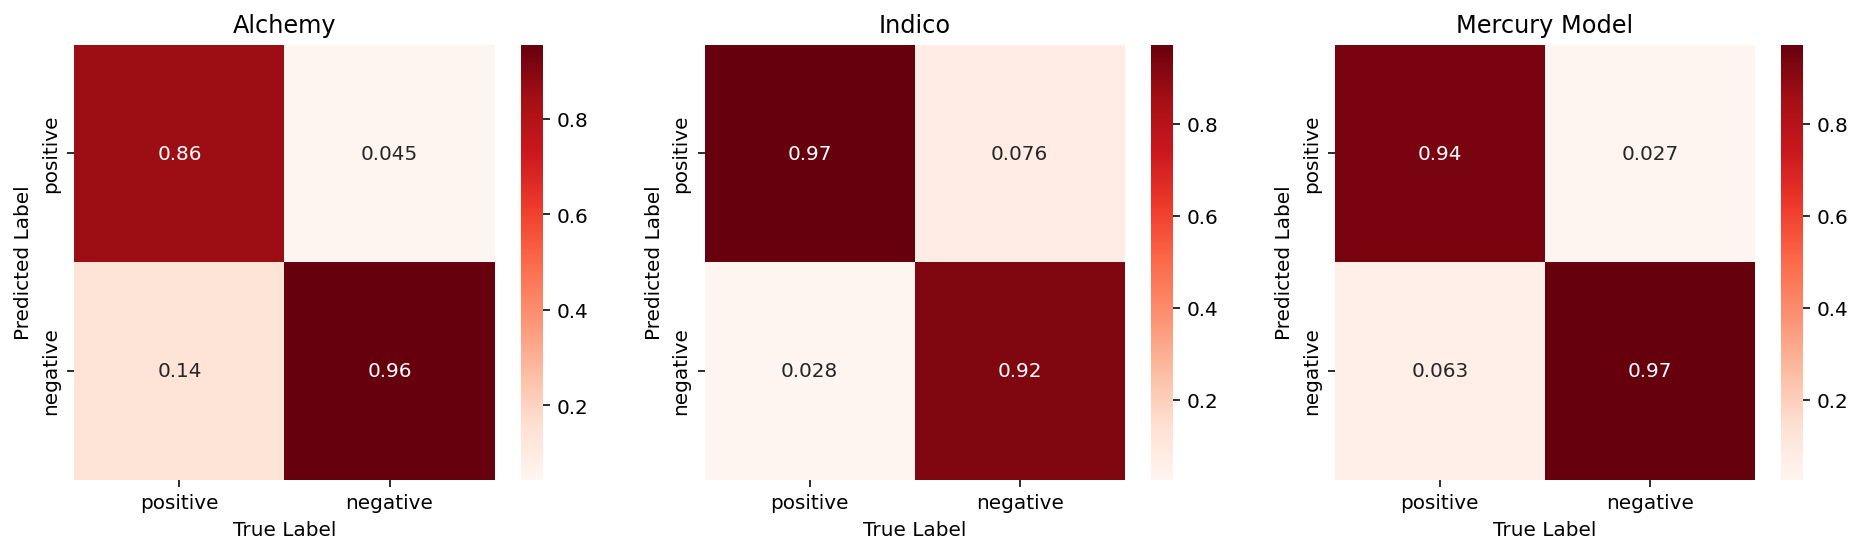

In [90]:
cm_alc = confusion_matrix(test_dataset['mturk_rating'], test_dataset['alchemy_rating']).T
cm_ind = confusion_matrix(test_dataset['mturk_rating'], test_dataset['indico_rating']).T
cm_mod = confusion_matrix(test_dataset['mturk_rating'], test_dataset['predict']).T

cm_alc = cm_alc.astype('float')/cm_alc.sum(axis=0)
cm_ind = cm_ind.astype('float')/cm_ind.sum(axis=0)
cm_mod = cm_mod.astype('float')/cm_mod.sum(axis=0)

fig, ax = subplots(nrows=1, ncols=3, figsize=(16,4))

classes = ['positive', 'negative']

tick_marks = np.arange(len(classes))

subplot(1, 3, 1)
sns.heatmap(cm_alc, annot=True, cmap='Reds')
xlabel('True Label')
ylabel('Predicted Label')
xticks(tick_marks + 0.5, classes)
yticks(tick_marks + 0.5, classes)
title('Alchemy')

subplot(1, 3, 2)
sns.heatmap(cm_ind, annot=True, cmap='Reds')
xlabel('True Label')
ylabel('Predicted Label')
xticks(tick_marks + 0.5, classes)
yticks(tick_marks + 0.5, classes)
title('Indico')

subplot(1, 3, 3)
sns.heatmap(cm_mod, annot=True, cmap='Reds')
xlabel('True Label')
ylabel('Predicted Label')
xticks(tick_marks + 0.5, classes)
yticks(tick_marks + 0.5, classes)
title('Mercury Model')
show()

The figures above compare the results of the Alchemy, Indico, and new Healthgrades model. The Alchemy model accurately predicts positive-sentiment comments 86% of the time, and misclassifies them 14% of the time. Similarly, it accurately classifies negative comments 96% of the time, and misclassifies them about 4% of the time.

The Indico model accurately predicts positive-sentiment comments 97% of the time, and misclassifies them about 3% of the time. Similarly, it accurately classifies negative comments 92% of the time, and misclassifies them about 8% of the time.

The new Mercury Healthcare model accurately predicts positive-sentiment comments 94% of the time, and misclassifies them about 6% of the time. Similarly, it accurately classifies negative comments 97% of the time, and misclassifies them 3% of the time.